In [5]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk 
from sklearn.ensemble import RandomForestClassifier 
from glob import glob,iglob
from osgeo import gdal , gdal_array
from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score, roc_auc_score,make_scorer
from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from write_geotif import CreateGeoTiff
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix

from yellowbrick.model_selection import FeatureImportances

from tqdm import tqdm
import joblib 
import earthpy.plot as ep

Data processing: to preprocess the data for some predictive modeling task, ensuring proper data types, handling categorical variables, and splitting the data into training and testing sets.

In [6]:
#Reading Data:This line reads a CSV file named "point_final.csv" into a pandas DataFrame (data_org) using pd.read_csv(). The delimiter used in the CSV file is ;.
data_org=pd.read_csv("point_final.csv",delimiter=";")

In [7]:
#Data Preprocessing:Here, a copy of the original DataFrame is created (data) to perform data preprocessing. In this step, commas in the data are replaced with periods. This is likely done to ensure consistency in representing decimal numbers.
data=data_org.copy()
data=data.replace(",",".",regex=True)

In [8]:
#Checking Data Types:This line prints out the data types of each column in the DataFrame data.
data.dtypes

OID_                  int64
Landslide             int64
LONGITUDE            object
LATITUDE             object
DTM_merged           object
slope                object
LULC                  int64
profile_curvature    object
plan_curvature       object
dist_acc_road        object
dist_river           object
NDVI                 object
rain                 object
aspect                int64
dtype: object

In [9]:
#Removing First Column:This line removes the first column from the DataFrame data. It's common in data processing tasks to remove index columns or columns that are not needed for analysis.
data=data.iloc[:,1:]

In [10]:
# Separate features and target variable: Here, the DataFrame X is created containing all the features (independent variables) except for the 'Landslide' column, while y contains only the 'Landslide' column, which is the target variable (dependent variable).
X=data.drop('Landslide', axis=1).copy()
y=data.loc[:,'Landslide'].copy()

In [11]:
X.head()

LONGITUDE     LATITUDE   DTM_merged        slope  LULC profile_curvature  \
0  91682.5802   92003.1689  373.0174866  0.787680209     4       -0.06276847   
1   55682.266  104415.2486  385.8379517  16.82241821     2      -0.269385904   
2  76261.6868   66915.8101  294.2075043  10.79049492     4       0.272305995   
3   56772.518  102116.9275  455.8366547  24.03018665     2      -0.174597126   
4  67847.8478   81082.7308  315.7912445  2.850139856     4        0.11769855   

  plan_curvature dist_acc_road   dist_river         NDVI         rain  aspect  
0    0.033129507   411.9653931  180.7027969  0.362031567  67.34322357       7  
1    0.087632157   258.0426331  148.4890594  0.335763618  82.88248444       6  
2   -0.318835378   580.9100647  373.3664398    0.4827781  71.41384125       8  
3    0.955412209   539.9199219  80.76198578  0.265183495  82.81878662       8  
4    0.001954662   138.8272247    569.63797  0.463345363  75.07782745       6

In [12]:
y.head()


0    0
1    0
2    0
3    0
4    0
Name: Landslide, dtype: int64

In [13]:
#Converting Data Types:This line converts all the columns in DataFrame X to float data type.
X=X.astype(float)
X.dtypes

LONGITUDE            float64
LATITUDE             float64
DTM_merged           float64
slope                float64
LULC                 float64
profile_curvature    float64
plan_curvature       float64
dist_acc_road        float64
dist_river           float64
NDVI                 float64
rain                 float64
aspect               float64
dtype: object

In [14]:
#Converting Categorical Variables:Here, specific columns ('aspect' and 'LULC') are converted to string data type. This might be done in preparation for one-hot encoding categorical variables.
#!!!!!uncomment when you have your aspect as categorical/factor variable fro example 1,2,3,4.....
X['aspect']=X['aspect'].astype(str)
X['LULC']=X['LULC'].astype(str)

In [15]:
#Checking Data Types: This line prints out the data type of the target variable y.
y.dtypes

dtype('int64')

In [16]:
#Identifying Categorical Columns:This line identifies categorical columns in the DataFrame X and stores their column names in the list cols_obj.
cols_obj=X.columns[X.dtypes=='object'].values.tolist()
cols_obj
#One-Hot Encoding Categorical Variables: This line performs one-hot encoding on the categorical variables identified earlier and stores the result in the DataFrame X_encoded.
X_encoded=pd.get_dummies(X,columns=cols_obj)

#Train-Test Split:This line splits the data into training and testing sets using train_test_split() function from scikit-learn. The training set comprises 70% of the data, and stratification is applied based on the target variable y.
X_train, X_test, y_train, y_test=train_test_split(X_encoded,y, random_state=6768, train_size=0.70, stratify=y)



In [17]:
cols_obj

['LULC', 'aspect']

In [18]:
X_train.shape

(799, 26)

In [19]:
X_test.shape

(343, 26)

In [20]:
X_encoded.columns

Index(['LONGITUDE', 'LATITUDE', 'DTM_merged', 'slope', 'profile_curvature',
       'plan_curvature', 'dist_acc_road', 'dist_river', 'NDVI', 'rain',
       'LULC_0.0', 'LULC_1.0', 'LULC_2.0', 'LULC_4.0', 'LULC_5.0', 'LULC_8.0',
       'aspect_0.0', 'aspect_1.0', 'aspect_2.0', 'aspect_3.0', 'aspect_4.0',
       'aspect_5.0', 'aspect_6.0', 'aspect_7.0', 'aspect_8.0', 'aspect_9.0'],
      dtype='object')

 XGBOOST: This code segment primarily focuses on training an XGBoost classifier, evaluating its performance, and optimizing its hyperparameters using grid search cross-validation. Let's break down the code step by step:
 Overall, this code trains an XGBoost classifier, evaluates its performance, visualizes the confusion matrix, and tunes its hyperparameters using grid search cross-validation to find the best combination of hyperparameters.

In [21]:
#Defining XGBoost Classifier:
clf_xgb=xgb.XGBClassifier(objective='binary:logistic', missing=np.nan,eval_metric='aucpr', early_stopping_rounds=10,seed=42)
#Fitting the Classifier: This line trains the XGBoost classifier (clf_xgb) on the training data (X_train, y_train) and evaluates it on the test set (X_test, y_test). The verbose=True argument prints the evaluation results during training.
clf_xgb.fit(X_train,y_train,verbose=True,eval_set=[(X_test,y_test)])


[0]	validation_0-aucpr:0.85562
[1]	validation_0-aucpr:0.87215
[2]	validation_0-aucpr:0.86338
[3]	validation_0-aucpr:0.87025
[4]	validation_0-aucpr:0.89001
[5]	validation_0-aucpr:0.89830
[6]	validation_0-aucpr:0.89287
[7]	validation_0-aucpr:0.89529
[8]	validation_0-aucpr:0.89652
[9]	validation_0-aucpr:0.90158
[10]	validation_0-aucpr:0.90822
[11]	validation_0-aucpr:0.90658
[12]	validation_0-aucpr:0.90134
[13]	validation_0-aucpr:0.90312
[14]	validation_0-aucpr:0.90852
[15]	validation_0-aucpr:0.90706
[16]	validation_0-aucpr:0.90534
[17]	validation_0-aucpr:0.90504
[18]	validation_0-aucpr:0.90448
[19]	validation_0-aucpr:0.89736
[20]	validation_0-aucpr:0.89497
[21]	validation_0-aucpr:0.89505
[22]	validation_0-aucpr:0.89530
[23]	validation_0-aucpr:0.89439


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
class_mapper={0:"No", 1:"Yes"}

In [23]:
class_mapper.keys()

dict_keys([0, 1])

In [24]:
class_mapper.values()

dict_values(['No', 'Yes'])

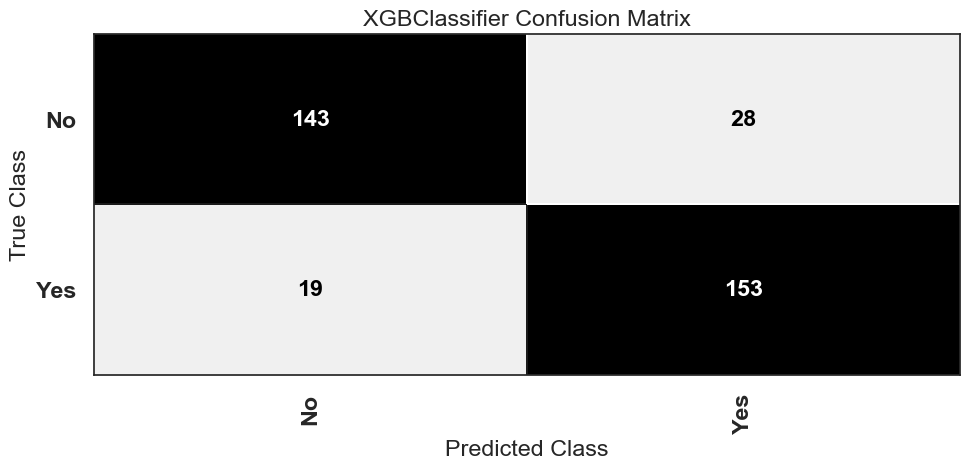

<Axes: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [25]:
sns.set(style="white",font_scale=1.4, rc={"font.weight": "bold"})
sns.set_style(style="white")
#cm = ConfusionMatrix(clf_xgb, classes=list(class_mapper.keys()))
#This part visualizes the confusion matrix of the trained model. It plots a confusion matrix using the ConfusionMatrix function, which helps in visualizing the performance of the classifier.
fig,ax=plt.subplots(figsize=(10,5))
cm = ConfusionMatrix(clf_xgb, classes=list(class_mapper.values()),cmap="Greys")
cm.fit(X_train,y_train)
cm.score(X_test,y_test)
cm.show()

This code segment seems to perform several tasks after obtaining the optimal parameters through grid search cross-validation. Let's break down the steps:

In [26]:
#Hyperparameter Tuning with Grid Search: Here, a dictionary param_grid is defined, which contains the hyperparameters and their respective values to be tuned.
param_grid={'max_depth':[3,4,5],
    'learning_rate':[0.1,0.05,0.01],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0],
    'scale_pos_weight':[1,3,5]}

In [27]:
#Grid Search Cross-Validation:An instance of GridSearchCV (optimal_params) is created with the XGBoost classifier as the estimator, the specified parameter grid, and other settings like verbosity, number of parallel jobs, and cross-validation folds.
optimal_params=GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', seed=42,subsample=0.9,eval_metric='aucpr',early_stopping_rounds=10),
                           param_grid=param_grid,verbose=2,n_jobs=16,cv=5)

In [28]:
#Fitting the Grid Search:The fit method is called on optimal_params to perform the grid search cross-validation on the training data. The evaluation is done on the test set as well.
optimal_params.fit(X_train,y_train,
                   verbose=True,
                   eval_set=[(X_test,y_test)])

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[0]	validation_0-aucpr:0.75383
[1]	validation_0-aucpr:0.75165
[2]	validation_0-aucpr:0.78445
[3]	validation_0-aucpr:0.78455
[4]	validation_0-aucpr:0.78820
[5]	validation_0-aucpr:0.78440
[6]	validation_0-aucpr:0.78089
[7]	validation_0-aucpr:0.81208
[8]	validation_0-aucpr:0.83142
[9]	validation_0-aucpr:0.84371
[10]	validation_0-aucpr:0.84680
[11]	validation_0-aucpr:0.85124
[12]	validation_0-aucpr:0.85354
[13]	validation_0-aucpr:0.86112
[14]	validation_0-aucpr:0.86464
[15]	validation_0-aucpr:0.87318
[16]	validation_0-aucpr:0.88551
[17]	validation_0-aucpr:0.88494
[18]	validation_0-aucpr:0.88591
[19]	validation_0-aucpr:0.88622
[20]	validation_0-aucpr:0.88622
[21]	validation_0-aucpr:0.88749
[22]	validation_0-aucpr:0.88948
[23]	validation_0-aucpr:0.88596
[24]	validation_0-aucpr:0.88820
[25]	validation_0-aucpr:0.88467
[26]	validation_0-aucpr:0.88292
[27]	validation_0-aucpr:0.88292
[28]	validation_0-aucpr:0.89115
[29]	validation_0-

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='aucpr', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=16,
             param_grid={'gamma': [0, 0.25, 1.0],
                         'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 4, 5], 'reg_lambda': [0, 1.0, 10.0],
                         'scale_pos_weight': [1, 3, 5]},
             verbose=2)

In [29]:
#Best Parameters:This line prints out the best parameters found by the grid search cross-validation.
optimal_params.best_params_

{'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_lambda': 10.0,
 'scale_pos_weight': 1}

In [101]:
#remeber to remove
# import pickle
# with open("./xgb_boost_finalized_model.sav", 'rb') as file:

#     optimal_parameters = pickle.load(file)
#Setting up XGBoost Classifier with Optimal Parameters: Here, an instance of the XGBoost classifier (clf_xgb) is created with the optimal parameters obtained from grid search cross-validation. Additionally, other settings such as the objective function, seed, and subsample are specified.
#clf_xgb=xgb.XGBClassifier(**optimal_parameters)

In [30]:
#Setting up XGBoost Classifier with Optimal Parameters: Here, an instance of the XGBoost classifier (clf_xgb) is created with the optimal parameters obtained from grid search cross-validation. Additionally, other settings such as the objective function, seed, and subsample are specified.
clf_xgb=xgb.XGBClassifier(objective='binary:logistic', missing=0,eval_metric='aucpr', early_stopping_rounds=10,seed=4442,
                          **optimal_params.best_params_,subsample=0.9)

In [105]:
optimal_parameters

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'eval_metric': 'aucpr',
 'gamma': 0,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': 10.0,
 'sampling_method': None,
 'scale_pos_weight': 1,
 'subsample': 0.9,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'seed': 4442}

In [106]:
#Fitting the Classifier and Training Set:This line fits the XGBoost classifier to the training data (X_train, y_train) and evaluates it on the test set (X_test, y_test). The verbose=True argument prints the evaluation results during training.
clf_xgb.fit(X_train,y_train,verbose=True,eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.77382
[1]	validation_0-aucpr:0.77874
[2]	validation_0-aucpr:0.79119
[3]	validation_0-aucpr:0.78527
[4]	validation_0-aucpr:0.79246
[5]	validation_0-aucpr:0.79153
[6]	validation_0-aucpr:0.80811
[7]	validation_0-aucpr:0.84599
[8]	validation_0-aucpr:0.85540
[9]	validation_0-aucpr:0.85546
[10]	validation_0-aucpr:0.85891
[11]	validation_0-aucpr:0.85903
[12]	validation_0-aucpr:0.86480
[13]	validation_0-aucpr:0.86276
[14]	validation_0-aucpr:0.86564
[15]	validation_0-aucpr:0.86866
[16]	validation_0-aucpr:0.86662
[17]	validation_0-aucpr:0.87525
[18]	validation_0-aucpr:0.87690
[19]	validation_0-aucpr:0.87963
[20]	validation_0-aucpr:0.87917
[21]	validation_0-aucpr:0.88076
[22]	validation_0-aucpr:0.87864
[23]	validation_0-aucpr:0.87676
[24]	validation_0-aucpr:0.87958
[25]	validation_0-aucpr:0.88019
[26]	validation_0-aucpr:0.87990
[27]	validation_0-aucpr:0.87983
[28]	validation_0-aucpr:0.88149
[29]	validation_0-aucpr:0.88157
[30]	validation_0-aucpr:0.88422
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [107]:
X_train

LONGITUDE     LATITUDE  DTM_merged      slope  profile_curvature  \
321   49848.0878  100267.0885  404.632416  16.809582           0.135305   
1115  89695.0000   90019.0000  353.415008  17.768637          -0.632733   
376   82078.0651   98264.6255  306.773453   2.824122           0.013427   
624   56854.4194   65176.4916  400.808990   2.743535          -0.021748   
575   77413.7941   81349.4616  230.217537   3.446514           0.026919   
...          ...          ...         ...        ...                ...   
96    81659.0355   90147.9564  304.052490  12.033729          -0.091309   
1076  92989.0000   63595.0000  229.800003  19.388506           0.417075   
796   75383.1660   89034.8312  309.070007   1.294650          -0.069368   
1048  79765.0000  101829.0000  241.242897   8.725870           1.713025   
23    84560.7258   68128.8470  300.595001   2.680599           0.047795   

      plan_curvature  dist_acc_road   dist_river      NDVI       rain  ...  \
321        -0.005950      66.925327    97.977036  0.331368  84.384460  ...   
1115       -0.768533      70.000000   594.229767  0.450290  67.041664  ...   
376         0.054874      30.805843    83.297642  0.501121  69.443787  ...   
624        -0.114540     147.492371   601.791504  0.408595  81.559036  ...   
575        -0.146082     159.050308   245.718338  0.351439  69.168785  ...   
...              ...            ...          ...       ...        ...  ...   
96          0.003311     139.846344    78.924011  0.413930  69.559464  ...   
1076        0.466161     421.921783   258.052322  0.487769  65.642372  ...   
796         0.001527     444.342224   248.471329  0.319260  68.575142  ...   
1048       -0.086424      74.632431    62.209316  0.460003  68.849998  ...   
23         -0.026389      57.982758  1057.432739  0.478872  69.615395  ...   

      aspect_0.0  aspect_1.0  aspect_2.0  aspect_3.0  aspect_4.0  aspect_5.0  \
321        False       False       False       False       False        True   
1115       False       False       False       False       False        True   
376        False       False       False        True       False       False   
624        False       False        True       False       False       False   
575        False       False       False       False       False       False   
...          ...         ...         ...         ...         ...         ...   
96         False       False       False       False       False        True   
1076       False       False       False       False       False       False   
796        False       False        True       False       False       False   
1048       False       False       False        True       False       False   
23         False       False       False       False       False        True   

      aspect_6.0  aspect_7.0  aspect_8.0  aspect_9.0  
321        False       False       False       False  
1115       False       False       False       False  
376        False       False       False       False  
624        False       False       False       False  
575        False       False        True       False  
...          ...         ...         ...         ...  
96         False       False       False       False  
1076       False       False        True       False  
796        False       False       False       False  
1048       False       False       False       False  
23         False       False       False       False  

[799 rows x 26 columns]

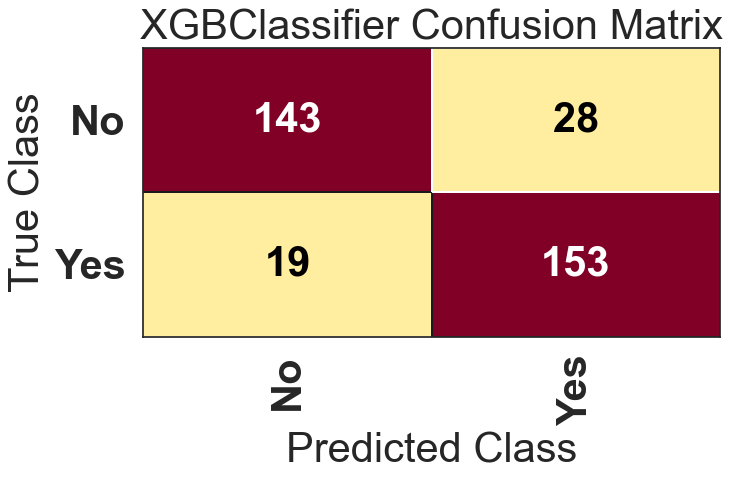

<Axes: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [108]:
#Visualizing Confusion Matrix:This section visualizes the confusion matrix of the trained model using the ConfusionMatrix visualizer. It helps in understanding the model's performance in terms of true positive, true negative, false positive, and false negative predictions.
cm = ConfusionMatrix(clf_xgb, classes=list(class_mapper.values()))
#cm = ConfusionMatrix(clf_xgb, classes=list(class_mapper.keys()),cmap="Greys")
cm.fit(X_train,y_train)
cm.score(X_test,y_test)
cm.show()

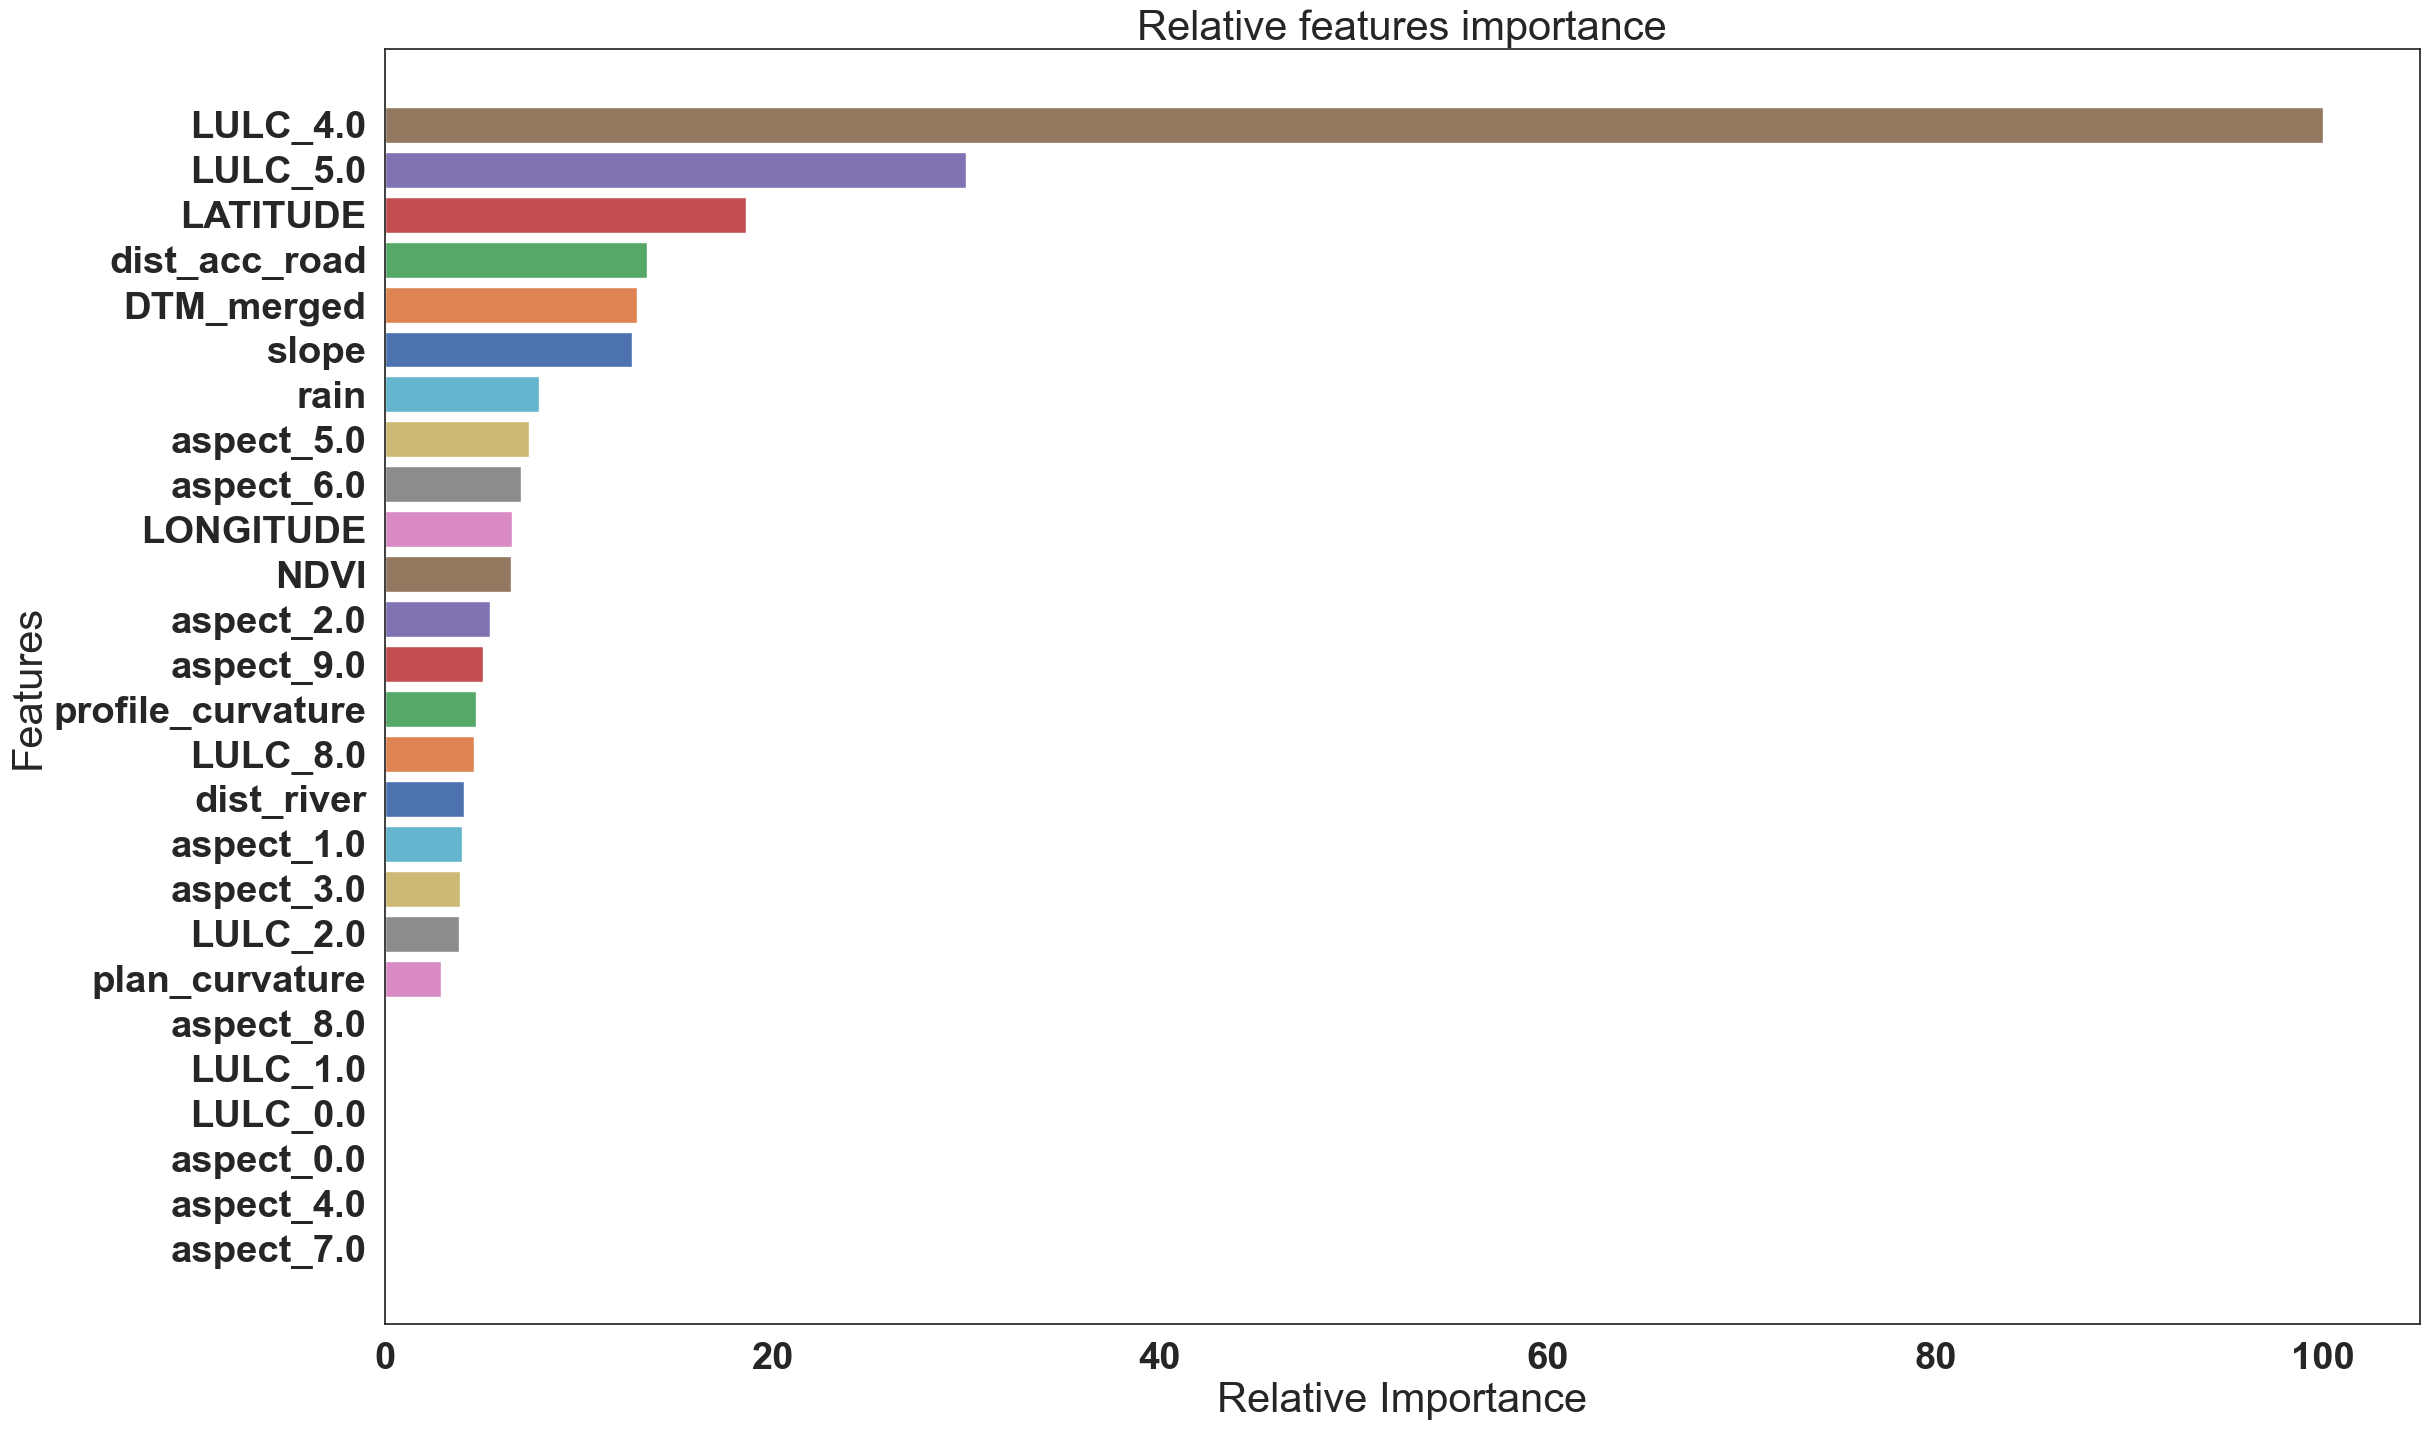

In [109]:
#Visualizing Feature Importances:Here, the code visualizes the relative importance of features in predicting the target variable using the FeatureImportances visualizer. This helps in understanding which features are more influential in the model's predictions
fig,ax=plt.subplots(figsize=(25,15))
viz = FeatureImportances(clf_xgb, relative=True, ax=ax)

viz.fit(X_train, y_train)
ax.set(title="Relative features importance", ylabel="Features", xlabel="Relative Importance")
fig.tight_layout()


In [110]:
original_palette = sns.color_palette("Greys")

# Create a reversed version of the palette
reversed_palette = original_palette[::-1]

In [111]:
#Visualizing Classification Report: This line initializes a visualizer for generating a classification report. It provides a detailed summary of the model's performance, including precision, recall, F1-score, and support for each class
visualizer = ClassificationReport(clf_xgb, classes=list(class_mapper.values()), support=False,cmap=reversed_palette)

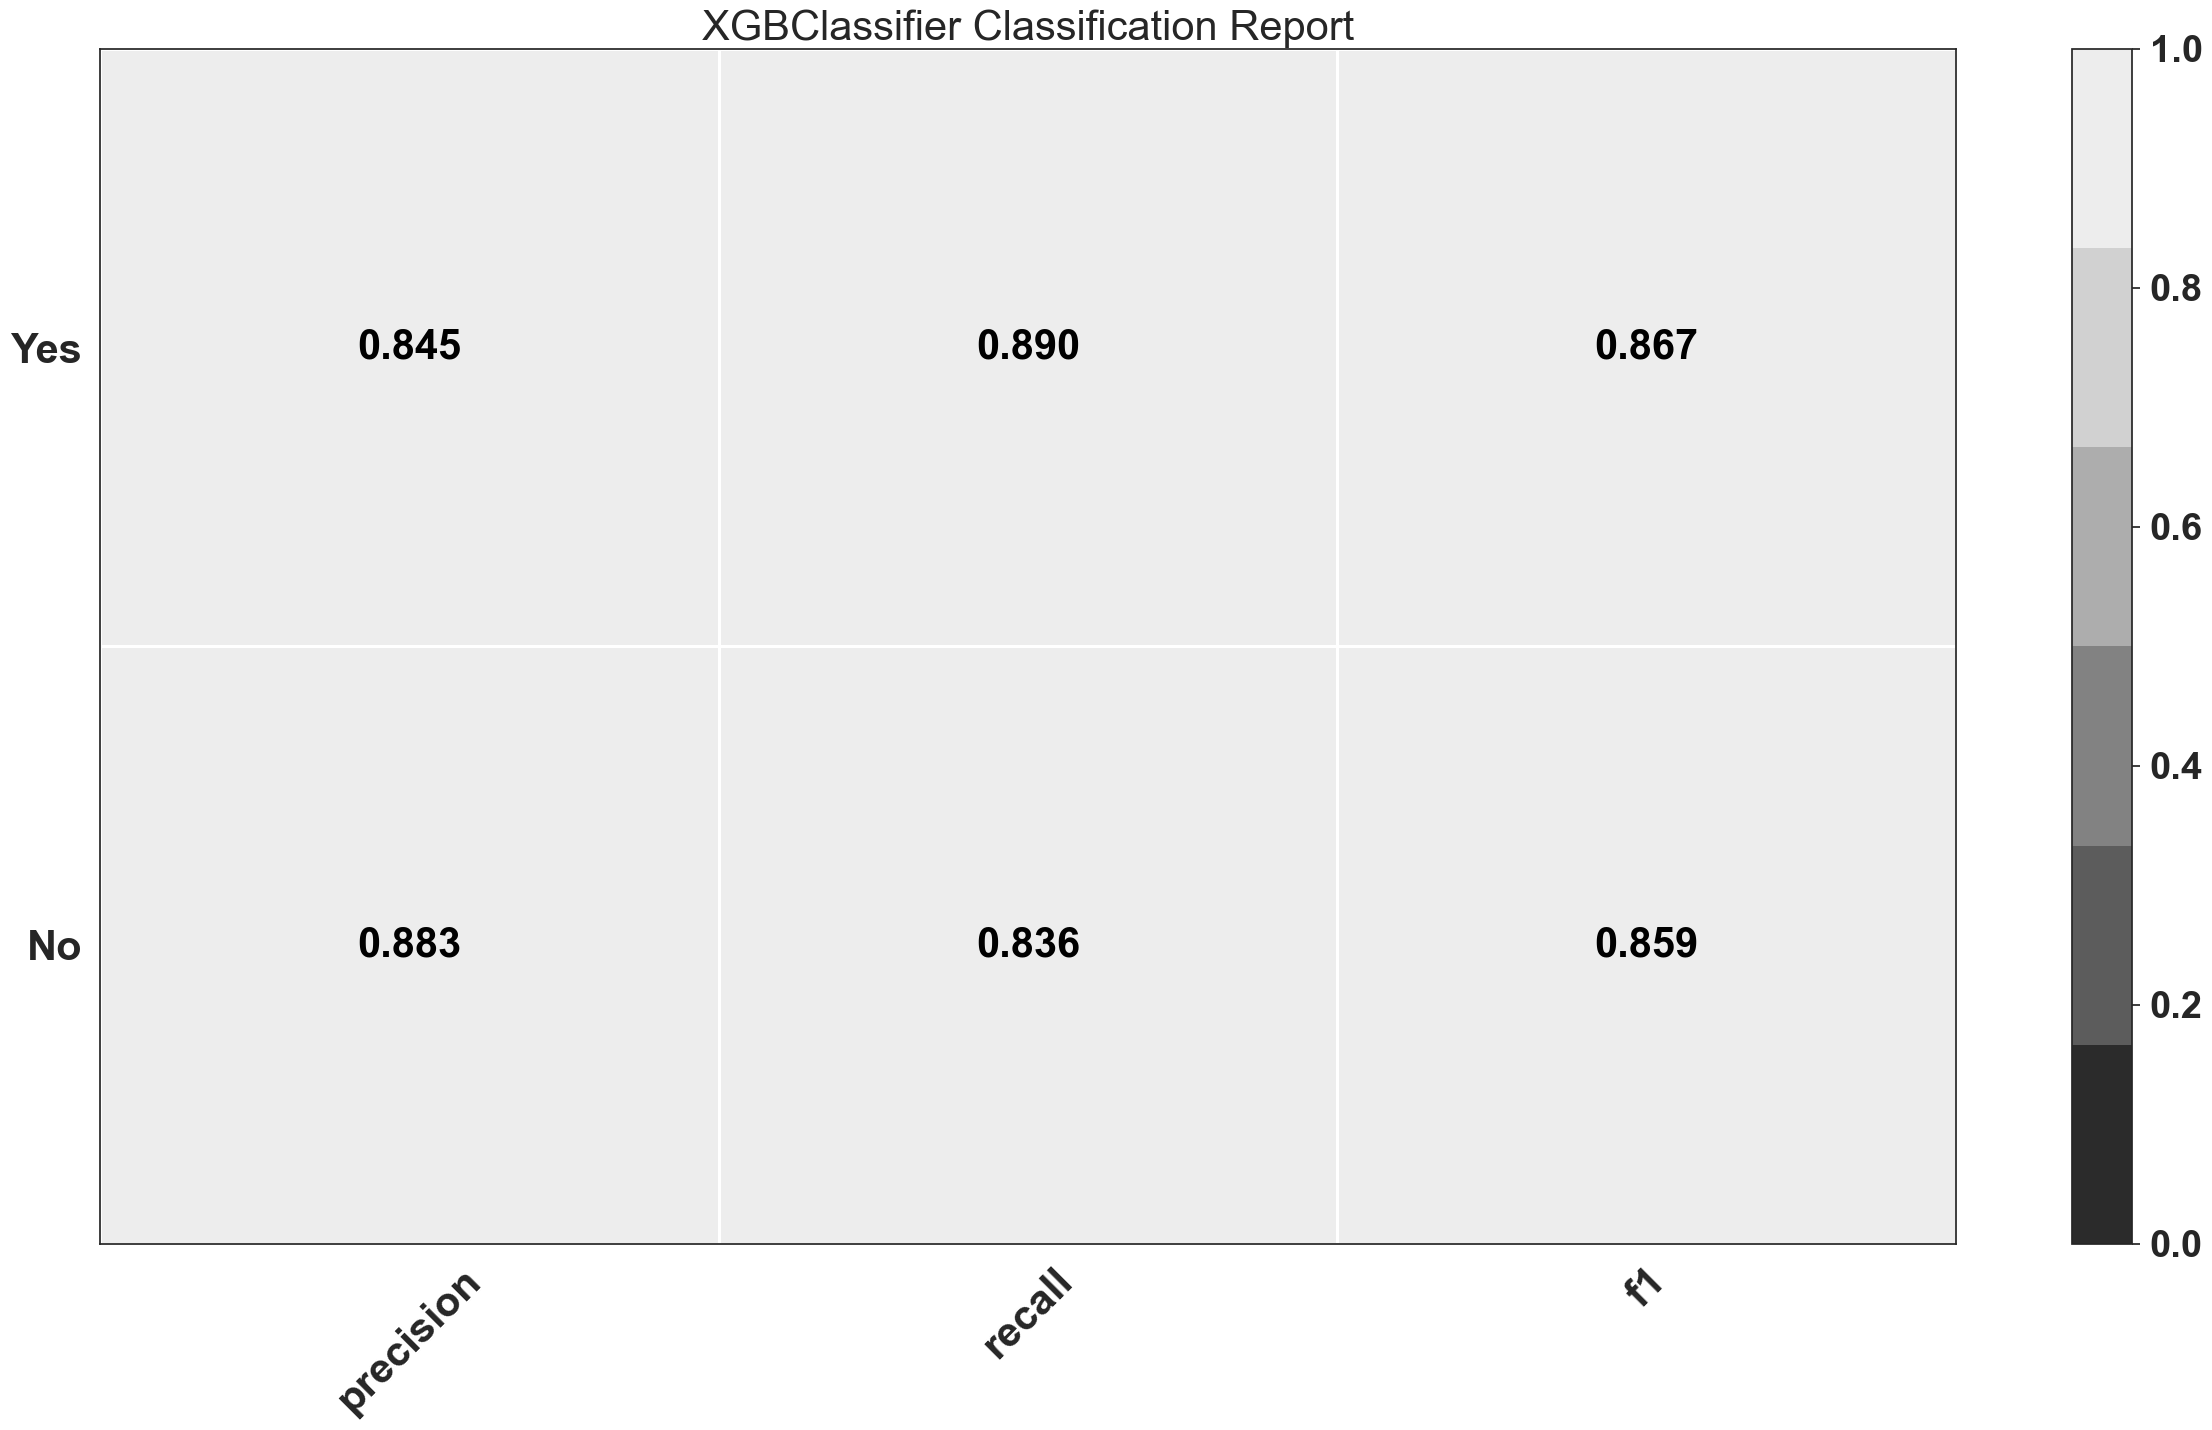

In [112]:
#Fitting and Displaying the Classification Report:This section fits the visualizer to the training data, evaluates it on the test data, and then displays the classification report. Additionally, it saves the visualization as an image file named "accuracy_assessment.png".
visualizer = ClassificationReport(clf_xgb, classes=list(class_mapper.values()), support=False,cmap=reversed_palette)
sns.set(style="white",font_scale=2.5, rc={"font.weight": "bold"})
sns.set_style(style="white")
#cm = ConfusionMatrix(clf_xgb, classes=list(class_mapper.keys()))
fig,ax=plt.subplots(figsize=(25,15))

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show(outpath="./accuracy_assessment.png")    
fig.tight_layout()

Overall, this code segment aims to provide a comprehensive assessment of the XGBoost classifier's performance, including visualizations of feature importances, confusion matrix, and a detailed classification report.

## prediction for the entire image 

This code segment is aimed at making predictions for an entire image using the trained XGBoost classifier and then saving the predicted probabilities as a GeoTIFF file. Let's break down the steps:

In [113]:
#Loading Image Files:
full_data_files=glob("F:/thesis/TEMP/project/data/*.tif")

In [114]:
full_data_files

['F:/thesis/TEMP/project/data\\aspect_clip.tif',
 'F:/thesis/TEMP/project/data\\clip_dtm.tif',
 'F:/thesis/TEMP/project/data\\dist_riv_mask.tif',
 'F:/thesis/TEMP/project/data\\DTM_merged_crop1.tif',
 'F:/thesis/TEMP/project/data\\LULC_clip1.tif',
 'F:/thesis/TEMP/project/data\\LULC_clip11.tif',
 'F:/thesis/TEMP/project/data\\NDVI_clip.tif',
 'F:/thesis/TEMP/project/data\\ndvi_rescale.tif',
 'F:/thesis/TEMP/project/data\\ndvi_rescale11.tif',
 'F:/thesis/TEMP/project/data\\plan_curvature.tif',
 'F:/thesis/TEMP/project/data\\plan_cur_clip.tif',
 'F:/thesis/TEMP/project/data\\profile_curvature.tif',
 'F:/thesis/TEMP/project/data\\prof_cur_clip.tif',
 'F:/thesis/TEMP/project/data\\rain_clip.tif',
 'F:/thesis/TEMP/project/data\\rain_clip11.tif',
 'F:/thesis/TEMP/project/data\\rain_resample.tif',
 'F:/thesis/TEMP/project/data\\rain_resample11.tif',
 'F:/thesis/TEMP/project/data\\reclass_aspect111.tif',
 'F:/thesis/TEMP/project/data\\resample_lulc.tif',
 'F:/thesis/TEMP/project/data\\resample

In [115]:
files_sorted = ['F:/thesis/TEMP/project/data\\clip_dtm.tif',
                'F:/thesis/TEMP/project/data\\slope1_clip.tif',
                'F:/thesis/TEMP/project/data\\LULC_clip11.tif',
                'F:/thesis/TEMP/project/data\\prof_cur_clip.tif',
                'F:/thesis/TEMP/project/data\\prof_cur_clip.tif',
                'F:/thesis/TEMP/project/data\\road_clip.tif',
                'F:/thesis/TEMP/project/data\\river_clip.tif',
                'F:/thesis/TEMP/project/data\\NDVI_clip.tif',
                'F:/thesis/TEMP/project/data\\rain_clip11.tif',
                'F:/thesis/TEMP/project/data\\aspect_clip.tif']


In [116]:
X_encoded.head()

LONGITUDE     LATITUDE  DTM_merged      slope  profile_curvature  \
0  91682.5802   92003.1689  373.017487   0.787680          -0.062768   
1  55682.2660  104415.2486  385.837952  16.822418          -0.269386   
2  76261.6868   66915.8101  294.207504  10.790495           0.272306   
3  56772.5180  102116.9275  455.836655  24.030187          -0.174597   
4  67847.8478   81082.7308  315.791245   2.850140           0.117699   

   plan_curvature  dist_acc_road  dist_river      NDVI       rain  ...  \
0        0.033130     411.965393  180.702797  0.362032  67.343224  ...   
1        0.087632     258.042633  148.489059  0.335764  82.882484  ...   
2       -0.318835     580.910065  373.366440  0.482778  71.413841  ...   
3        0.955412     539.919922   80.761986  0.265183  82.818787  ...   
4        0.001955     138.827225  569.637970  0.463345  75.077827  ...   

   aspect_0.0  aspect_1.0  aspect_2.0  aspect_3.0  aspect_4.0  aspect_5.0  \
0       False       False       False       False       False       False   
1       False       False       False       False       False       False   
2       False       False       False       False       False       False   
3       False       False       False       False       False       False   
4       False       False       False       False       False       False   

   aspect_6.0  aspect_7.0  aspect_8.0  aspect_9.0  
0       False        True       False       False  
1        True       False       False       False  
2       False       False        True       False  
3       False       False        True       False  
4        True       False       False       False  

[5 rows x 26 columns]

In [117]:
X_encoded.columns

Index(['LONGITUDE', 'LATITUDE', 'DTM_merged', 'slope', 'profile_curvature',
       'plan_curvature', 'dist_acc_road', 'dist_river', 'NDVI', 'rain',
       'LULC_0.0', 'LULC_1.0', 'LULC_2.0', 'LULC_4.0', 'LULC_5.0', 'LULC_8.0',
       'aspect_0.0', 'aspect_1.0', 'aspect_2.0', 'aspect_3.0', 'aspect_4.0',
       'aspect_5.0', 'aspect_6.0', 'aspect_7.0', 'aspect_8.0', 'aspect_9.0'],
      dtype='object')

In [118]:
#Loading Image Data:Here, each TIFF file is opened using GDAL, and its data is read as an array within a specified subset.
full_data_array=[]
#subset=(0,0, 6860,4064)
subset=(0,0, 1000,1000)
for i in files_sorted:
    full_data_array.append(gdal.Open(i).ReadAsArray(*subset))

In [119]:
#temp=gdal.Open(files_sorted[3])
#temp=temp.ReadAsArray()

In [120]:
len(full_data_array)

full_data_array

[array([[3.4000000e+38, 3.4000000e+38, 3.4000000e+38, ..., 3.4000000e+38,
         3.4000000e+38, 3.4000000e+38],
        [3.4000000e+38, 3.4536844e+02, 3.4545593e+02, ..., 3.2793594e+02,
         3.2779813e+02, 3.2772031e+02],
        [3.4000000e+38, 3.4537344e+02, 3.4545248e+02, ..., 3.2800314e+02,
         3.2786938e+02, 3.2780734e+02],
        ...,
        [3.4000000e+38, 3.0799561e+02, 3.0833218e+02, ..., 2.7857812e+02,
         2.7827658e+02, 2.7804938e+02],
        [3.4000000e+38, 3.0817438e+02, 3.0846063e+02, ..., 2.7860846e+02,
         2.7830093e+02, 2.7807718e+02],
        [3.4000000e+38, 3.0830658e+02, 3.0858124e+02, ..., 2.7869034e+02,
         2.7839407e+02, 2.7818344e+02]], dtype=float32),
 array([[ 3.9183056,  3.8969402,  5.0904055, ..., 11.989588 ,  9.816357 ,
          8.510258 ],
        [ 3.9744542,  4.2215085,  4.864669 , ..., 12.905796 ,  9.8213625,
          7.3417277],
        [ 4.1462955,  4.00364  ,  4.364813 , ..., 12.180277 ,  9.447374 ,
          6.915899 ]

In [121]:
#convert back to array
#np.array([full_data_array[1]]).shape # to convert 2D dimension to 3D array to make concatenation possible 
#full_data_array=np.concatenate(full_data_array, axis =1)
#Stacking Image Data: The arrays obtained from each TIFF file are stacked along a new axis to form a 3D array, representing the entire dataset.
full_data_array=np.stack(full_data_array)

In [122]:
dimension=full_data_array.shape
dimension

(10, 1000, 1000)

In [123]:
#Reshaping Image Data:The 3D array is reshaped into a 2D array for further processing.
full_data_array=full_data_array.reshape(10,(dimension[1]*dimension[2]))

In [124]:
full_data_array.shape

(10, 1000000)

In [125]:
full_data_array=full_data_array.swapaxes(0,1)
full_data_array.shape

(1000000, 10)

In [126]:
#for longitude and latitude 
meta_data=gdal.Open(files_sorted[2])

In [127]:
geotransform=meta_data.GetGeoTransform()
geotransform

(72258.87973294931, 1.0, 0.0, 88383.76677642332, 0.0, -1.000246062992126)

In [128]:
meta_data.GetProjection()

'PROJCS["LUREF_Transverse_Mercator",GEOGCS["Luxembourg 1930",DATUM["Luxembourg_1930",SPHEROID["International 1924",6378388,297.000000000005,AUTHORITY["EPSG","7022"]],AUTHORITY["EPSG","6181"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4181"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49.8333333333333],PARAMETER["central_meridian",6.16666666666667],PARAMETER["scale_factor",1],PARAMETER["false_easting",80000],PARAMETER["false_northing",100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In [129]:
band_description=meta_data.GetRasterBand(1)

In [130]:
band_description.XSize

6861

In [131]:
band_description.YSize

4064

In [132]:
subset

(0, 0, 1000, 1000)

In [133]:
#Creating Longitude and Latitude Arrays: Longitude and latitude arrays are generated based on the geotransform information obtained from one of the TIFF files
#long=[geotransform[0]+ i for i in range(band_description.XSize-1)]
#lat=[ geotransform[3] -i for i in range (band_description.YSize) ]

long=[geotransform[0]+ i for i in range(subset[2])]
lat=[ geotransform[3] -i for i in range(subset[3] )]

In [134]:
len(long)

1000

In [135]:
len(lat)



1000

In [136]:
#full_data_array[100,1]

In [137]:
#full_data_array[100,2]

In [138]:
#full_data_array[100,3]

In [139]:
#np.c_[np.arange(1,10).ravel(),np.arange(100,109).ravel()]

In [140]:

#r,c=np.meshgrid(np.arange(1,10),np.arange(100,109))


In [141]:
#r
#np.c_[r.ravel(),c.ravel()]

In [142]:
xx,yy=np.meshgrid(np.array(long),np.array(lat))
#xx_yy_matrix=np.vstack((np.ravel(xx), np.ravel(yy)))
xx_yy_matrix=np.c_[xx.ravel(), yy.ravel()]

In [143]:
xx_yy_matrix.shape

(1000000, 2)

In [144]:
full_data_array.shape

(1000000, 10)

In [145]:
#Concatenating Longitude, Latitude, and Image Data:Longitude, latitude, and image data arrays are concatenated horizontally to form a single array representing the entire dataset.
full_data_array=np.hstack((xx_yy_matrix,full_data_array))

In [146]:
full_data_array.shape

(1000000, 12)

In [147]:
full_data_array[:,5]

array([ 2.0842452 , -0.12942636, -5.67899275, ..., -4.48127747,
       -9.21927547, -4.23269606])

In [148]:
#Converting to DataFrame and One-Hot Encoding:The concatenated array is converted to a DataFrame, and one-hot encoding is applied to categorical variables.
full_data_array_df=pd.DataFrame(full_data_array, columns=X.columns)

In [149]:
full_data_array_df

LONGITUDE      LATITUDE    DTM_merged      slope  LULC  \
0       72258.879733  88383.766776  3.400000e+38   3.918306   2.0   
1       72259.879733  88383.766776  3.400000e+38   3.896940   2.0   
2       72260.879733  88383.766776  3.400000e+38   5.090405   2.0   
3       72261.879733  88383.766776  3.400000e+38   5.586890   2.0   
4       72262.879733  88383.766776  3.400000e+38   4.758517   2.0   
...              ...           ...           ...        ...   ...   
999995  73253.879733  87384.766776  2.792956e+02  18.900774   2.0   
999996  73254.879733  87384.766776  2.789885e+02  17.945953   2.0   
999997  73255.879733  87384.766776  2.786903e+02  17.382925   2.0   
999998  73256.879733  87384.766776  2.783941e+02  16.875957   2.0   
999999  73257.879733  87384.766776  2.781834e+02  14.874692   2.0   

        profile_curvature  plan_curvature  dist_acc_road  dist_river  \
0                2.084245        2.084245     871.455078  500.695526   
1               -0.129426       -0.129426     871.690857  501.474823   
2               -5.678993       -5.678993     871.927734  502.254913   
3               -1.017010       -1.017010     872.165710  503.035797   
4                2.595974        2.595974     872.404724  503.817413   
...                   ...             ...            ...         ...   
999995           0.292089        0.292089     137.992752  158.041138   
999996          -0.866937       -0.866937     137.058380  157.267288   
999997          -4.481277       -4.481277     136.124939  156.486420   
999998          -9.219275       -9.219275     135.192459  155.708054   
999999          -4.232696       -4.232696     134.260941  154.932236   

            NDVI       rain  aspect  
0       0.466146  70.125427     8.0  
1       0.466146  70.125427     8.0  
2       0.466146  70.125427     7.0  
3       0.466146  70.125427     7.0  
4       0.466146  70.125427     7.0  
...          ...        ...     ...  
999995  0.442185  70.125427     3.0  
999996  0.442185  70.125427     3.0  
999997  0.442185  70.125427     3.0  
999998  0.442185  70.125427     2.0  
999999  0.442185  70.125427     2.0  

[1000000 rows x 12 columns]

In [150]:
full_data_array_df['aspect']=full_data_array_df['aspect'].astype(str)
full_data_array_df['LULC']=full_data_array_df['LULC'].astype(str)
cols_obj_full=full_data_array_df.columns[full_data_array_df.dtypes=='object'].values.tolist()
cols_obj_full
full_data_array_df_encoded=pd.get_dummies(full_data_array_df,columns=cols_obj_full)

In [151]:
full_data_array_df_encoded.columns

Index(['LONGITUDE', 'LATITUDE', 'DTM_merged', 'slope', 'profile_curvature',
       'plan_curvature', 'dist_acc_road', 'dist_river', 'NDVI', 'rain',
       'LULC_2.0', 'LULC_4.0', 'LULC_5.0', 'LULC_8.0', 'aspect_1.0',
       'aspect_2.0', 'aspect_3.0', 'aspect_4.0', 'aspect_5.0', 'aspect_6.0',
       'aspect_7.0', 'aspect_8.0', 'aspect_9.0'],
      dtype='object')

In [152]:
#full_data_array_df["LULC"].unique()

In [153]:
X_encoded.columns

Index(['LONGITUDE', 'LATITUDE', 'DTM_merged', 'slope', 'profile_curvature',
       'plan_curvature', 'dist_acc_road', 'dist_river', 'NDVI', 'rain',
       'LULC_0.0', 'LULC_1.0', 'LULC_2.0', 'LULC_4.0', 'LULC_5.0', 'LULC_8.0',
       'aspect_0.0', 'aspect_1.0', 'aspect_2.0', 'aspect_3.0', 'aspect_4.0',
       'aspect_5.0', 'aspect_6.0', 'aspect_7.0', 'aspect_8.0', 'aspect_9.0'],
      dtype='object')

In [154]:
# List of missing columns in full_data_array_df_encoded
#missing_columns = ['LULC_0.0', 'LULC_1.0', 'LULC_3.0', 'LULC_6.0', 'LULC_7.0', 'aspect_0.0']



In [155]:
# Assuming X_encoded and full_data_array_df_encoded are your DataFrames
missing_columns = [c for c in X_encoded.columns if c not in full_data_array_df_encoded.columns]
missing_columns

['LULC_0.0', 'LULC_1.0', 'aspect_0.0']

In [156]:
# Add missing columns to full_data_array_df_encoded and fill with false
for col in missing_columns:
    full_data_array_df_encoded[col] = False

In [157]:
full_data_array_df_encoded.columns
#X_encoded.shape
#==X_encoded.columns

Index(['LONGITUDE', 'LATITUDE', 'DTM_merged', 'slope', 'profile_curvature',
       'plan_curvature', 'dist_acc_road', 'dist_river', 'NDVI', 'rain',
       'LULC_2.0', 'LULC_4.0', 'LULC_5.0', 'LULC_8.0', 'aspect_1.0',
       'aspect_2.0', 'aspect_3.0', 'aspect_4.0', 'aspect_5.0', 'aspect_6.0',
       'aspect_7.0', 'aspect_8.0', 'aspect_9.0', 'LULC_0.0', 'LULC_1.0',
       'aspect_0.0'],
      dtype='object')

In [158]:
#filter/subset columns to confrom with ur training data
#Columns in the DataFrame are filtered to match those used during training, and their order is rearranged accordingly.
full_data_array_df_encoded=full_data_array_df_encoded[X_encoded.columns]

In [159]:
# Reordering columns to match the model's feature order
full_data_array_df_encoded = full_data_array_df_encoded[X_encoded.columns]

In [160]:
#np.all(full_data_array_df_encoded.columns==X_encoded.columns)


In [161]:
X_encoded.columns

Index(['LONGITUDE', 'LATITUDE', 'DTM_merged', 'slope', 'profile_curvature',
       'plan_curvature', 'dist_acc_road', 'dist_river', 'NDVI', 'rain',
       'LULC_0.0', 'LULC_1.0', 'LULC_2.0', 'LULC_4.0', 'LULC_5.0', 'LULC_8.0',
       'aspect_0.0', 'aspect_1.0', 'aspect_2.0', 'aspect_3.0', 'aspect_4.0',
       'aspect_5.0', 'aspect_6.0', 'aspect_7.0', 'aspect_8.0', 'aspect_9.0'],
      dtype='object')

In [162]:
# Making predictions using the XGBoost model
#predictions = clf_xgb.predict(full_data_array_df_encoded)
predictions = clf_xgb.predict_proba(full_data_array_df_encoded)
#probability of occurence 
predictions_occ=predictions[:,1]
#Reshaping Predictions:The predicted probabilities are reshaped to match the dimensions of the original image.
l=predictions_occ.reshape(dimension[1:])

In [163]:
predictions_occ

array([0.13647214, 0.12767477, 0.13367352, ..., 0.74385715, 0.7670017 ,
       0.76598275], dtype=float32)

In [164]:
dimension[1]*dimension[2]

1000000

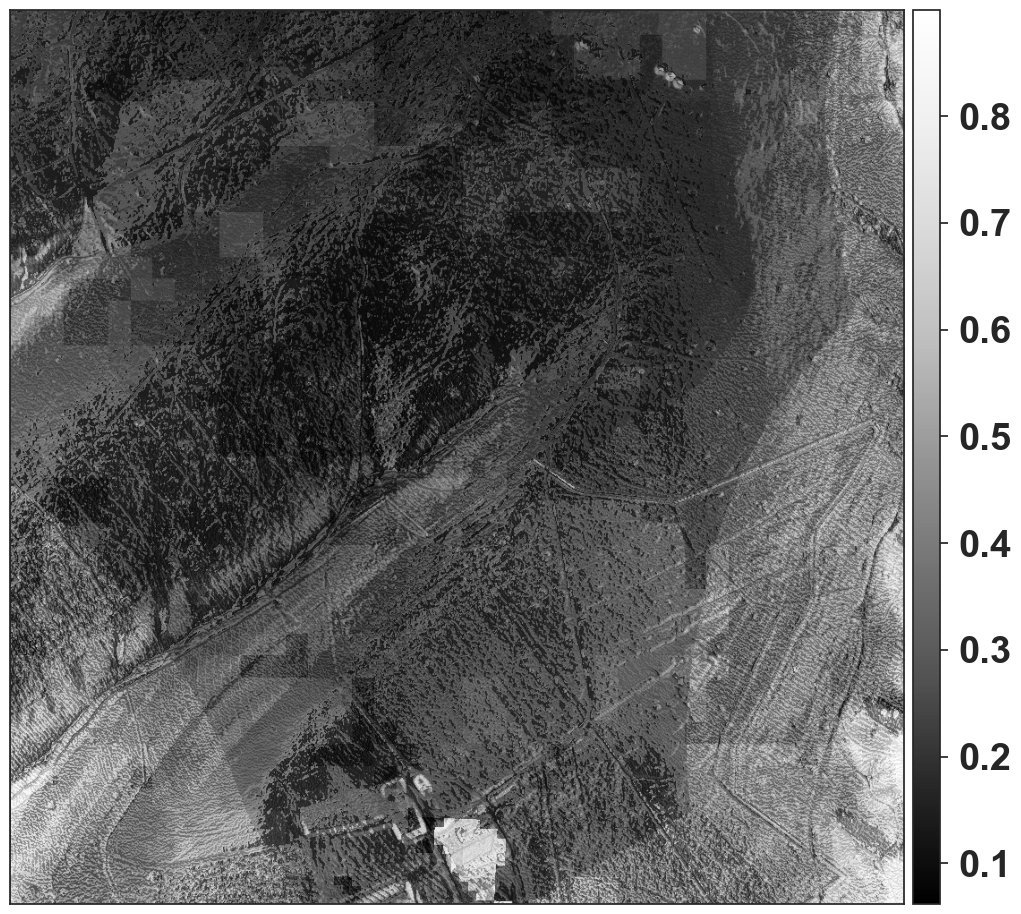

<Axes: >

In [165]:
ep.plot_bands(l)

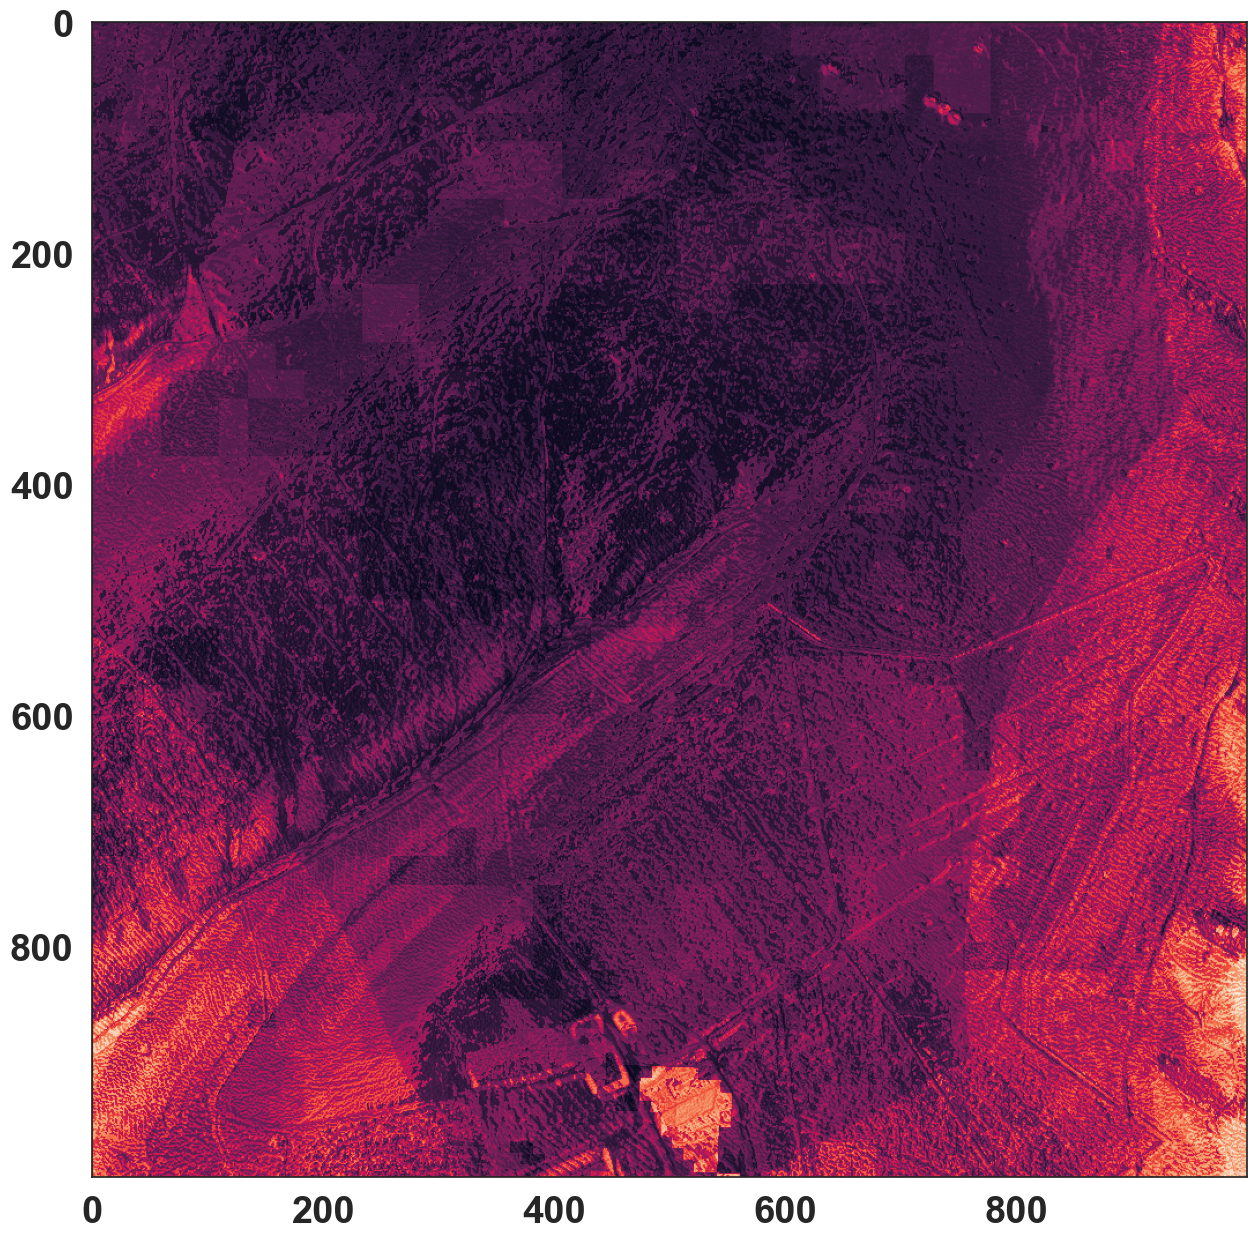

In [166]:
fig,ax=plt.subplots(figsize=(15,15))
plt.imshow(l)

In [167]:
"""
def CreateGeoTiff(Name, Array, DataType, NDV,bandnames=None,ref_image=None, 
                  GeoT=None, Projection=None):
    # If it's a 2D image we fake a third dimension:
    if len(Array.shape)==2:
        Array=np.array([Array])
    if ref_image==None and (GeoT==None or Projection==None):
        raise RuntimeWarning('ref_image or settings required.')
    if bandnames != None:
        if len(bandnames) != Array.shape[0]:
            raise RuntimeError('Need {} bandnames. {} given'
                               .format(Array.shape[0],len(bandnames)))
    else:
        bandnames=['Band {}'.format(i+1) for i in range(Array.shape[0])]
    if ref_image!= None:
        refimg=gdal.Open(ref_image)
        GeoT=refimg.GetGeoTransform()
        Projection=refimg.GetProjection()
    driver= gdal.GetDriverByName('GTIFF')
    Array[np.isnan(Array)] = NDV
    DataSet = driver.Create(Name, 
            Array.shape[2], Array.shape[1], Array.shape[0], DataType)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection( Projection)
    for i, image in enumerate(Array, 1):
        DataSet.GetRasterBand(i).WriteArray( image )
        DataSet.GetRasterBand(i).SetNoDataValue(NDV)
        DataSet.SetDescription(bandnames[i-1])
    DataSet.FlushCache()
    return Name
"""

"\ndef CreateGeoTiff(Name, Array, DataType, NDV,bandnames=None,ref_image=None, \n                  GeoT=None, Projection=None):\n    # If it's a 2D image we fake a third dimension:\n    if len(Array.shape)==2:\n        Array=np.array([Array])\n    if ref_image==None and (GeoT==None or Projection==None):\n        raise RuntimeWarning('ref_image or settings required.')\n    if bandnames != None:\n        if len(bandnames) != Array.shape[0]:\n            raise RuntimeError('Need {} bandnames. {} given'\n                               .format(Array.shape[0],len(bandnames)))\n    else:\n        bandnames=['Band {}'.format(i+1) for i in range(Array.shape[0])]\n    if ref_image!= None:\n        refimg=gdal.Open(ref_image)\n        GeoT=refimg.GetGeoTransform()\n        Projection=refimg.GetProjection()\n    driver= gdal.GetDriverByName('GTIFF')\n    Array[np.isnan(Array)] = NDV\n    DataSet = driver.Create(Name, \n            Array.shape[2], Array.shape[1], Array.shape[0], DataType)\n    Data

In [168]:
gdal_type=gdal_array.NumericTypeCodeToGDALTypeCode(l.dtype)
gdal_type

6

In [169]:
#Saving Predictions as GeoTIFF:
CreateGeoTiff("./classification/test_subset_1000.tif",l,gdal_type,-9999,["Band_1"],GeoT=meta_data.GetGeoTransform(),Projection=meta_data.GetProjection())

'./classification/test_subset_1000.tif'

Finally, the predicted probabilities are saved as a GeoTIFF file using the provided function CreateGeoTiff. This GeoTIFF file can be further processed or visualized using GIS software.

## RandomForest

In [91]:
#goto
clf_rf=RandomForestClassifier(n_estimators=300, oob_score=True)

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'eval_metric': 'aucpr',
 'gamma': 0,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': 10.0,
 'sampling_method': None,
 'scale_pos_weight': 1,
 'subsample': 0.9,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'seed': 4442}

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'eval_metric': 'aucpr',
 'gamma': 0,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': 10.0,
 'sampling_method': None,
 'scale_pos_weight': 1,
 'subsample': 0.9,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'seed': 4442}

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'eval_metric': 'aucpr',
 'gamma': 0,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': 10.0,
 'sampling_method': None,
 'scale_pos_weight': 1,
 'subsample': 0.9,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'seed': 4442}

In [92]:
#Model Training:This line fits (trains) the Random Forest classifier clf_rf using the training data X_train and corresponding labels y_train.
clf_rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=300, oob_score=True)

C:\TEMP\thesis\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


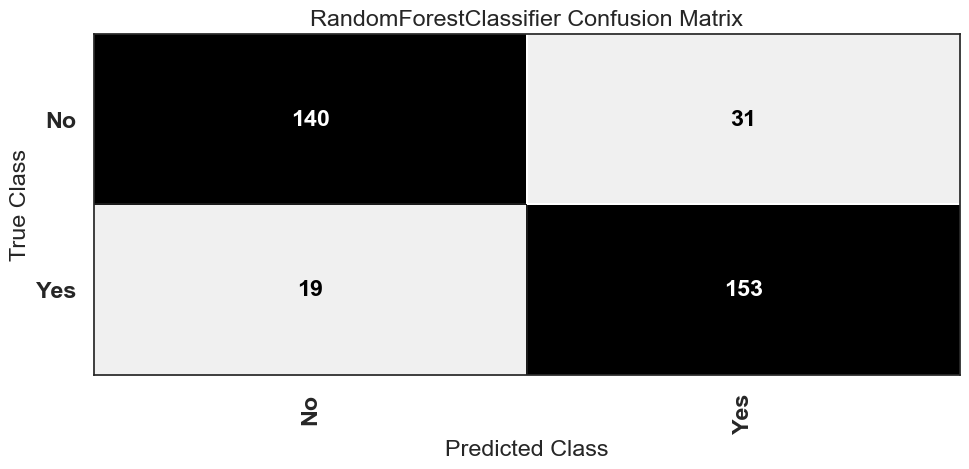

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [93]:
sns.set(style="white",font_scale=1.4, rc={"font.weight": "bold"})
sns.set_style(style="white")
#cm = ConfusionMatrix(clf_xgb, classes=list(class_mapper.keys()))
fig,ax=plt.subplots(figsize=(10,5))
cm_rf = ConfusionMatrix(clf_rf, classes=list(class_mapper.values()),cmap="Greys")
cm_rf.fit(X_train,y_train)
cm_rf.score(X_test,y_test)
cm_rf.show()

C:\TEMP\thesis\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


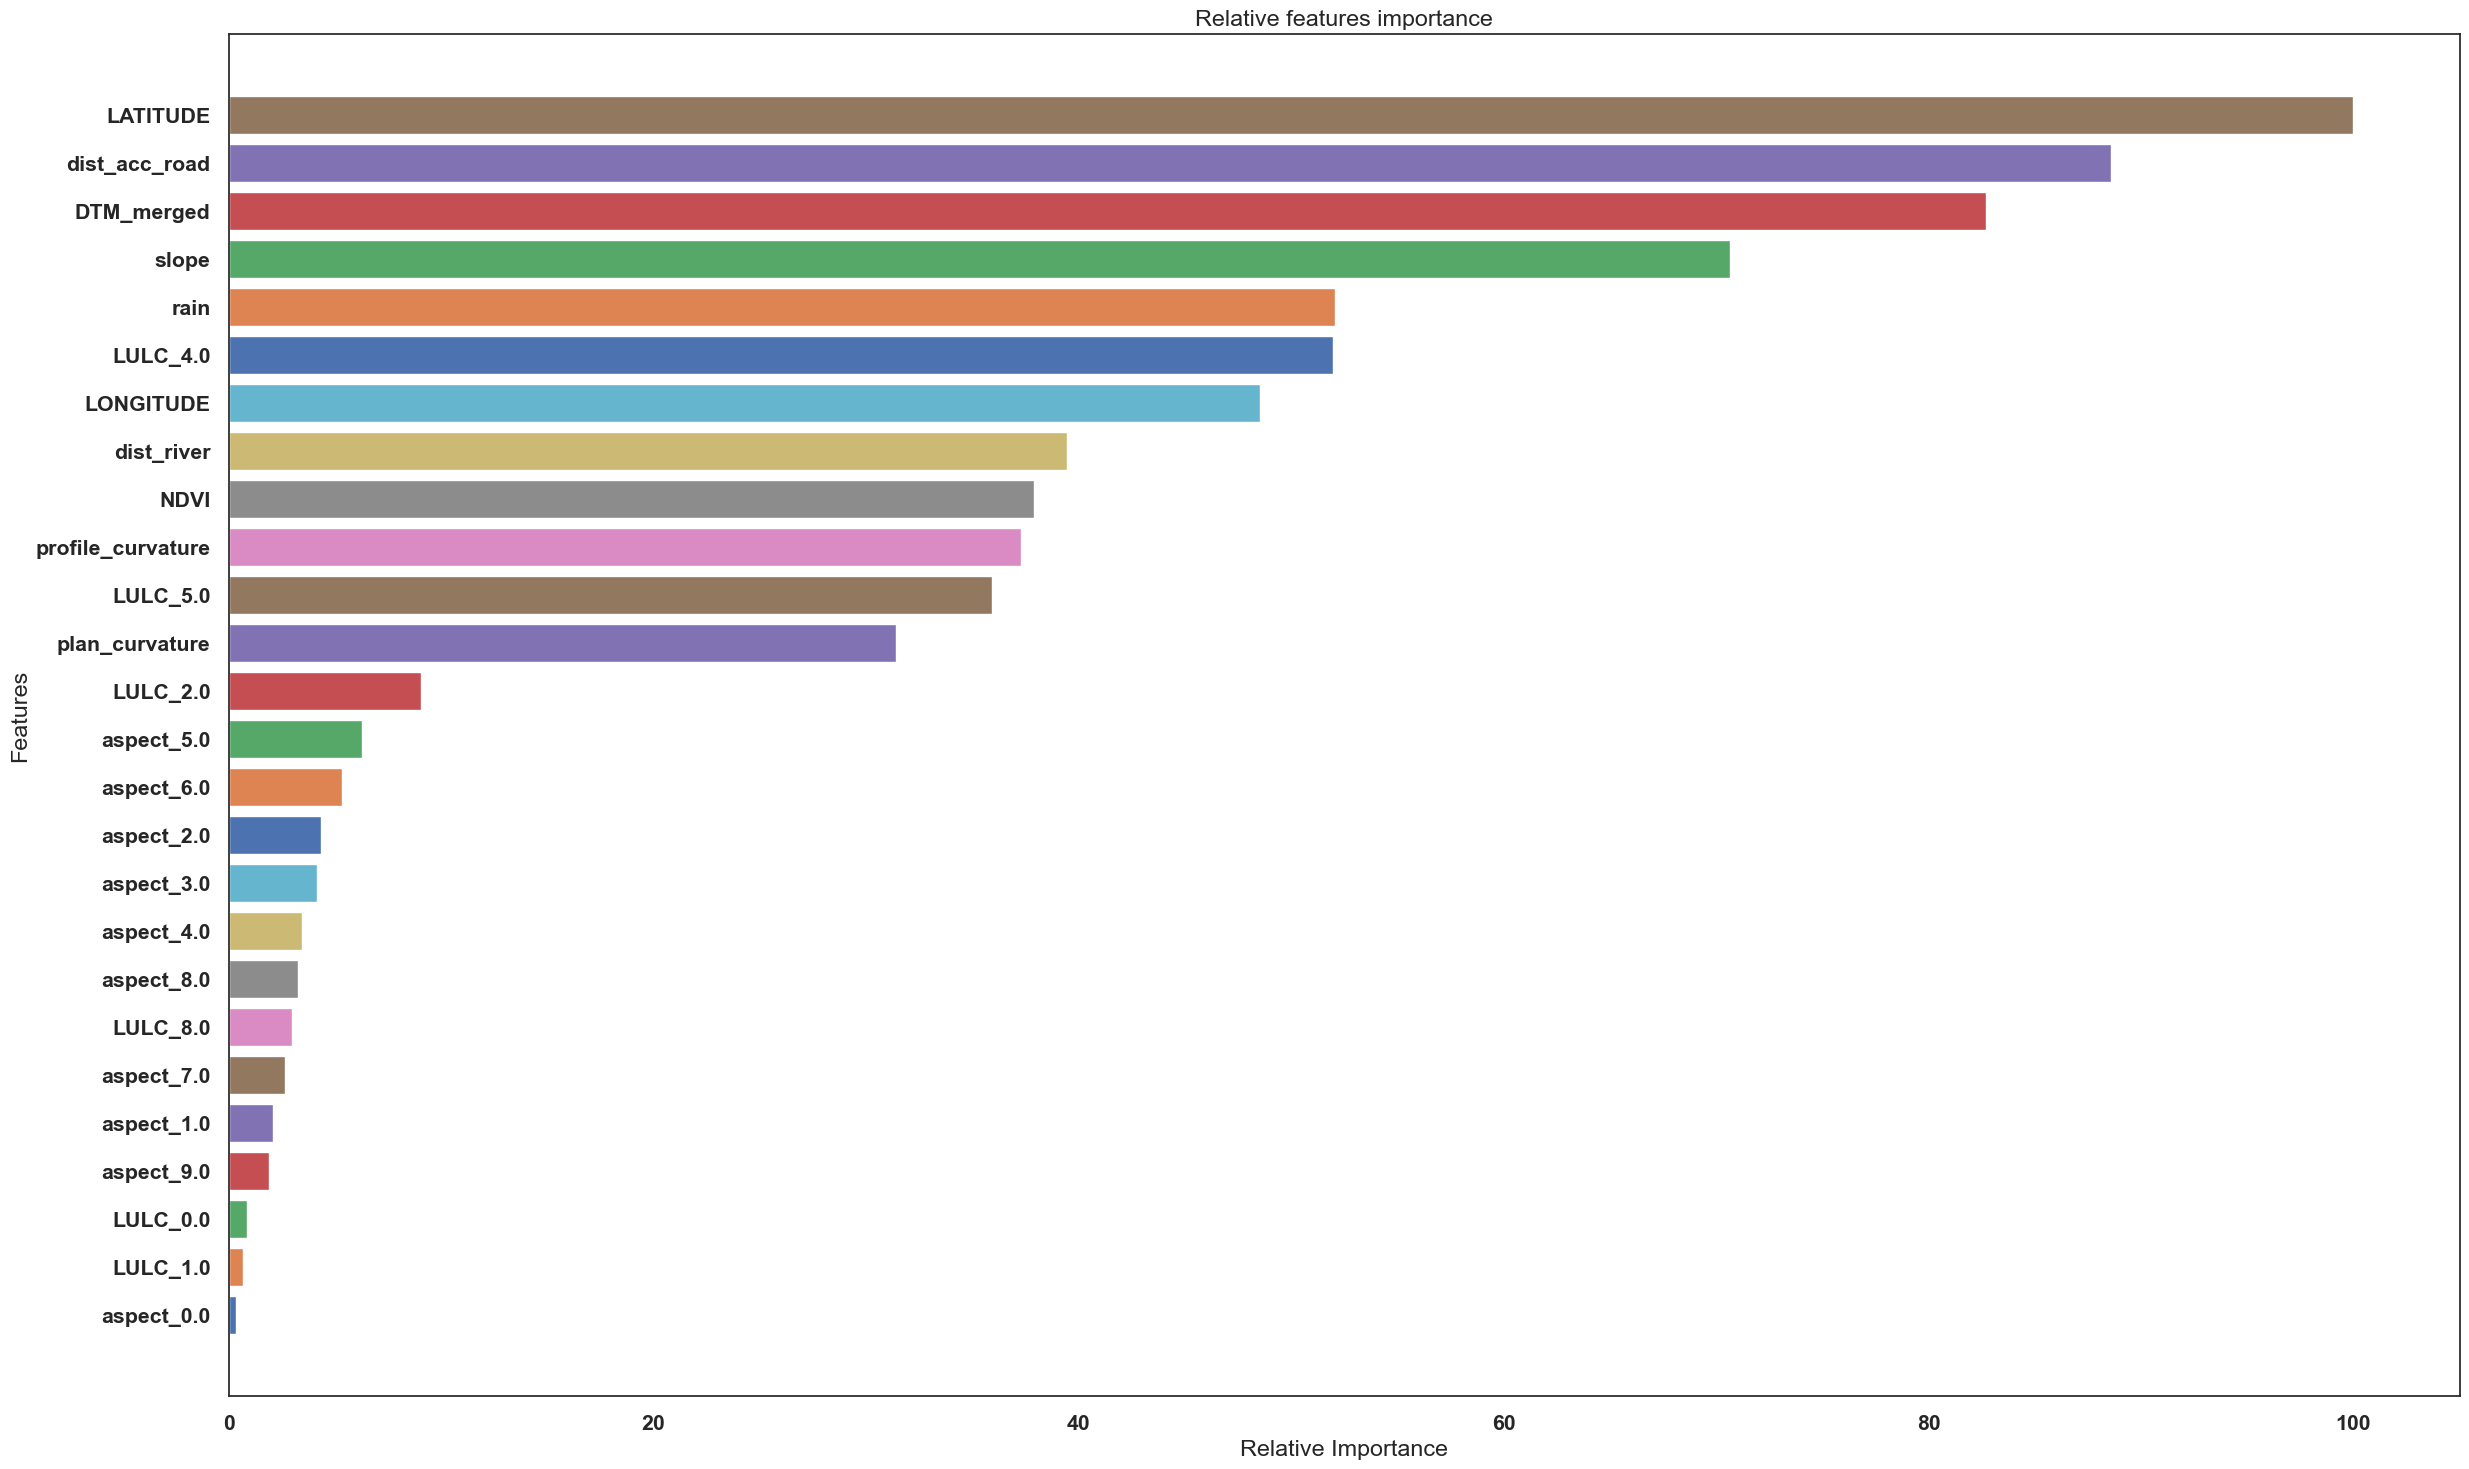

In [94]:
fig,ax=plt.subplots(figsize=(25,15))
viz_rf = FeatureImportances(clf_rf, relative=True, ax=ax)

viz_rf.fit(X_train, y_train)
ax.set(title="Relative features importance", ylabel="Features", xlabel="Relative Importance")
fig.tight_layout()


C:\TEMP\thesis\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


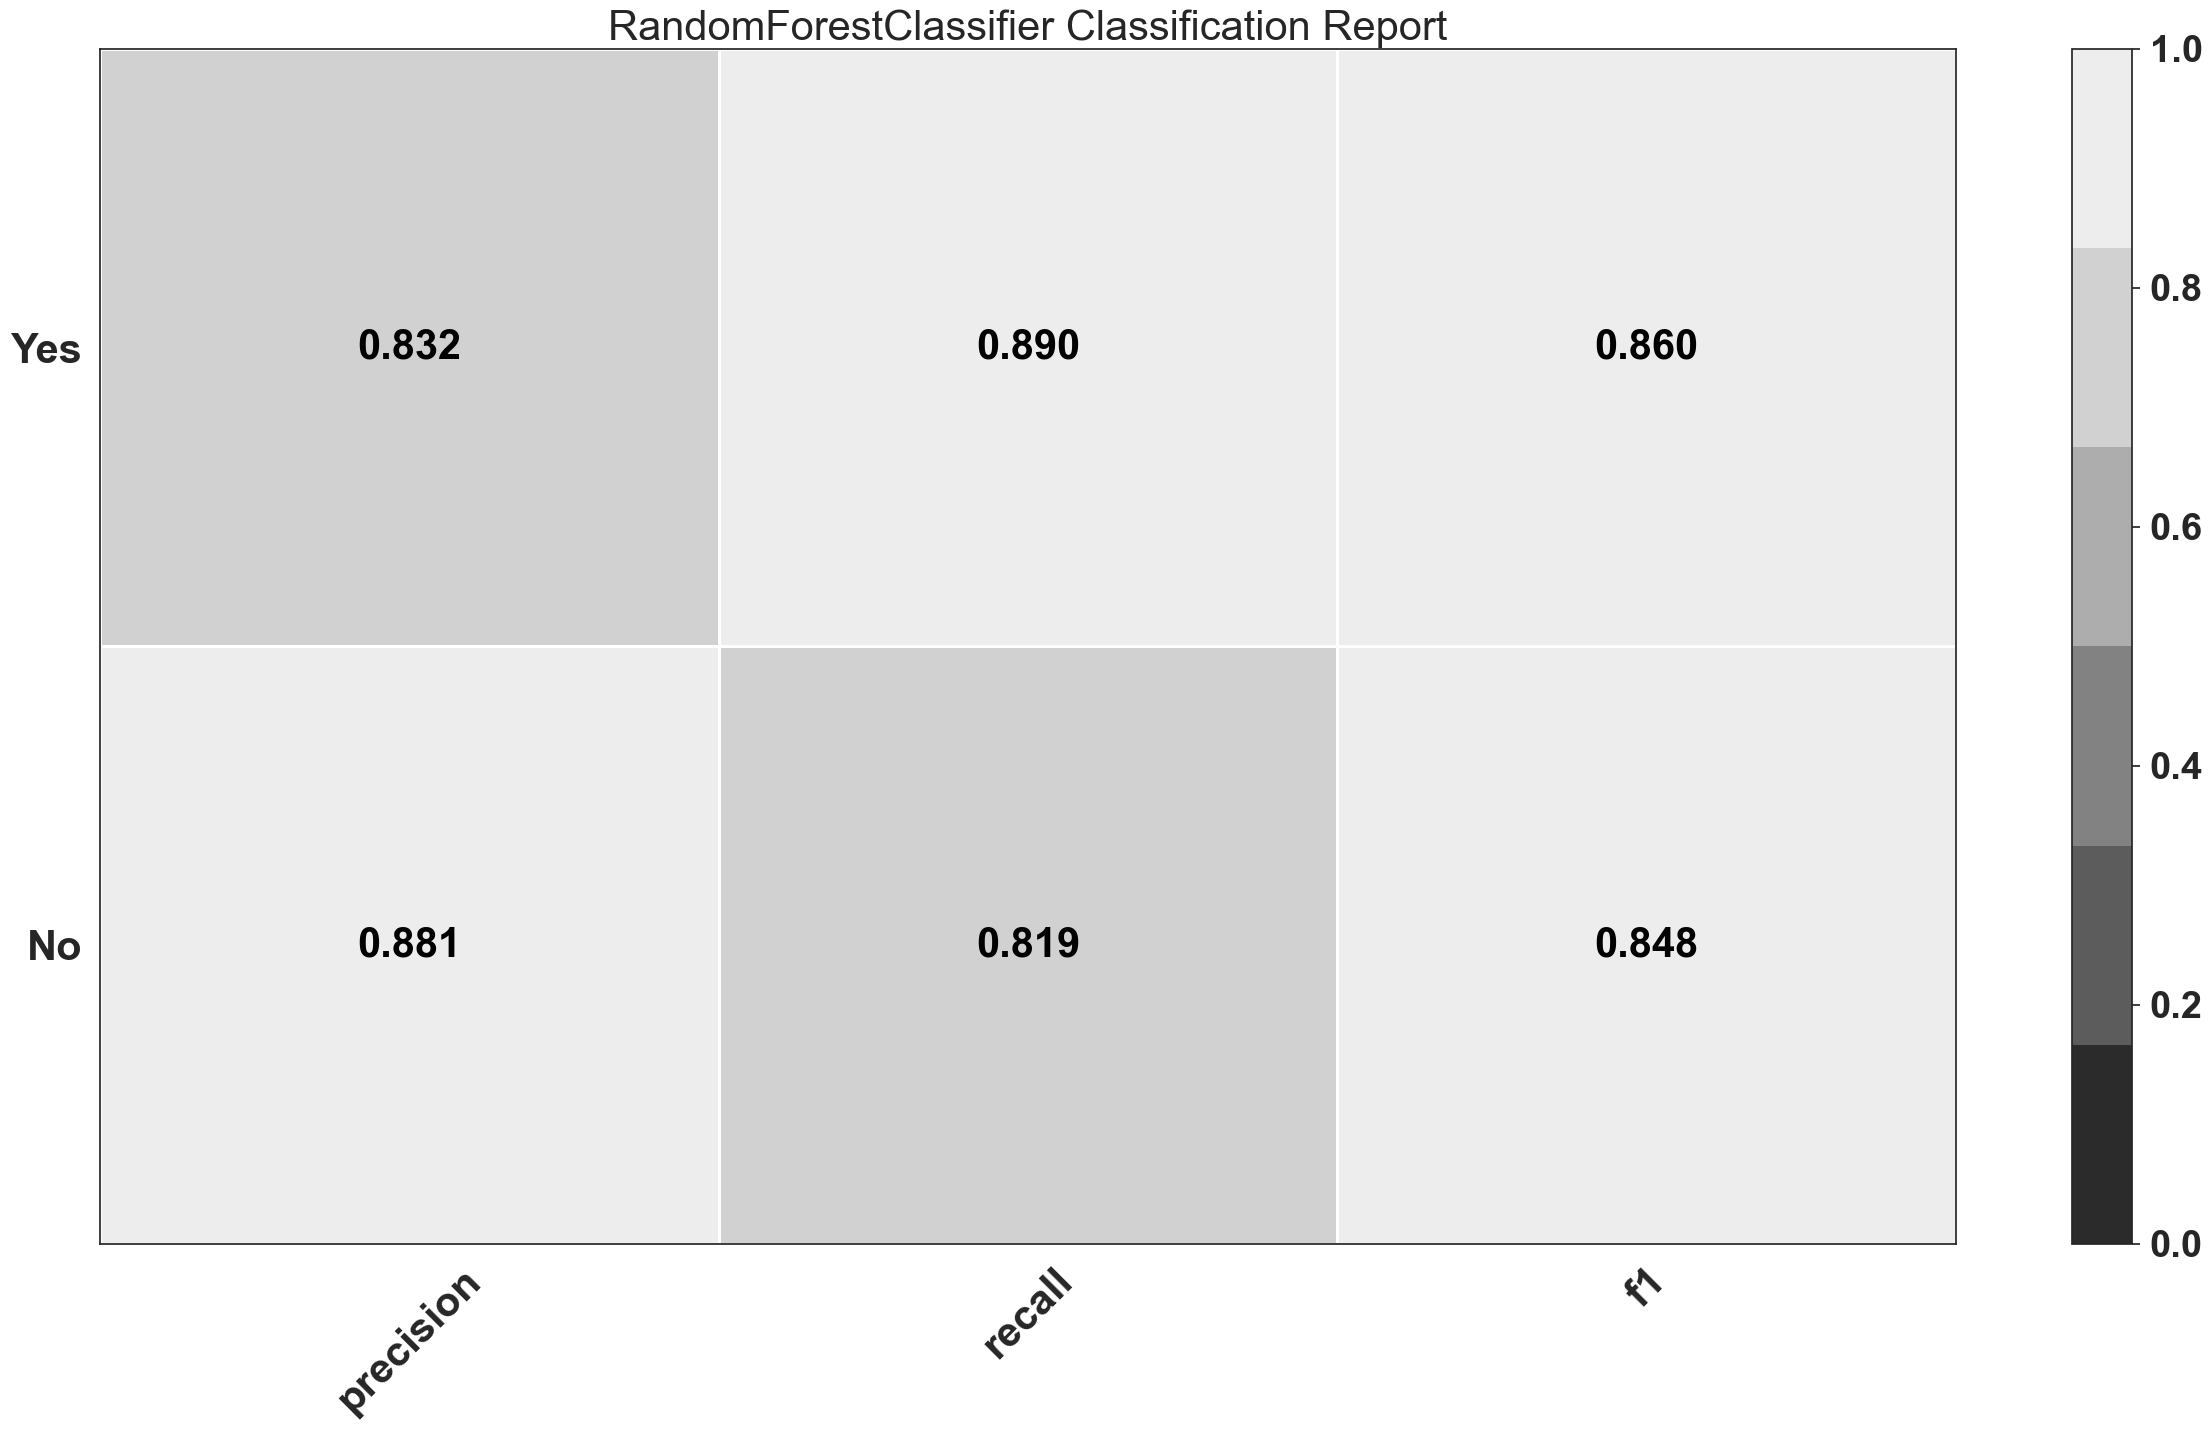

In [95]:

visualizer_rf = ClassificationReport(clf_rf, classes=list(class_mapper.values()), support=False,cmap=reversed_palette)
sns.set(style="white",font_scale=2.5, rc={"font.weight": "bold"})
sns.set_style(style="white")
fig,ax=plt.subplots(figsize=(25,15))
visualizer_rf.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer_rf.score(X_test, y_test)        # Evaluate the model on the test data
visualizer_rf.show(outpath="./accuracy_assessment_random_forest.png")    
fig.tight_layout()

In [96]:
# Making predictions using the XGBoost model
#predictions = clf_xgb.predict(full_data_array_df_encoded)
predictions_rf = clf_rf.predict_proba(full_data_array_df_encoded)
#probability of occurence 
predictions_occ_rf=predictions[:,1]
l_rf=predictions_occ_rf.reshape(dimension[1:])

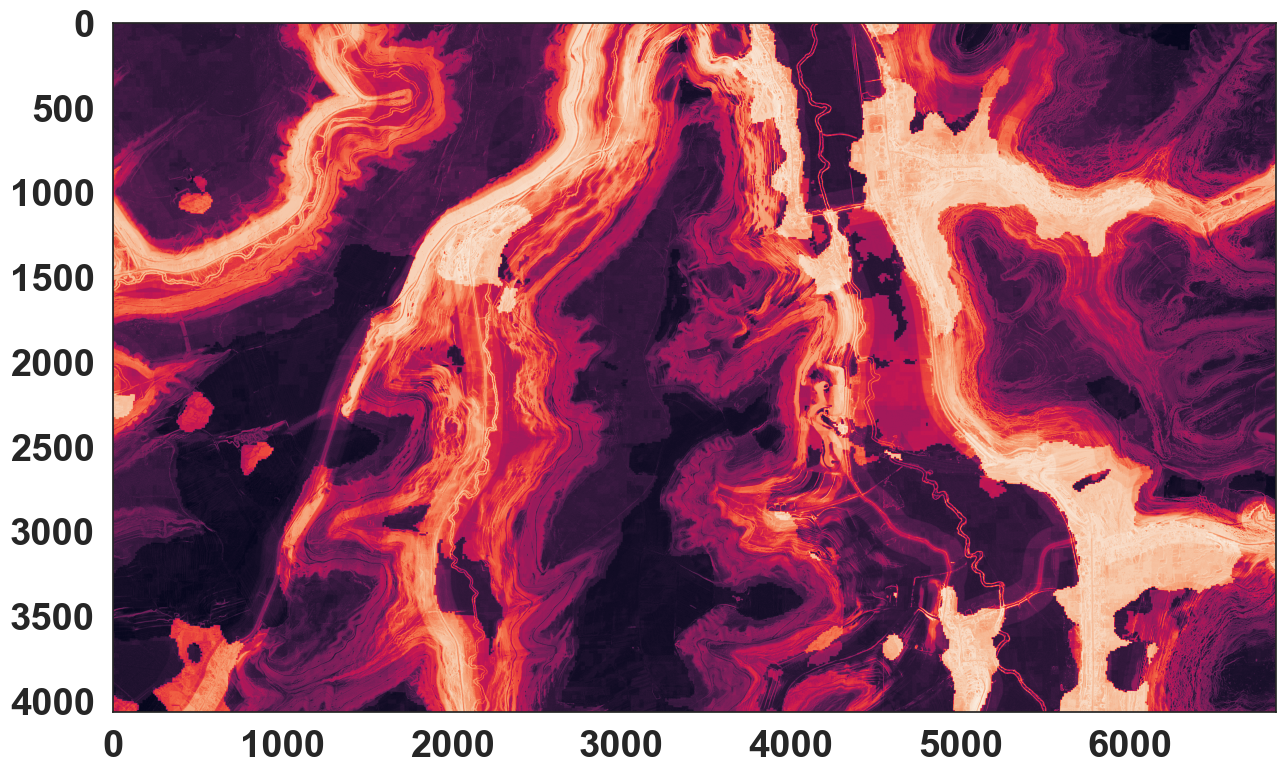

In [97]:
fig,ax=plt.subplots(figsize=(15,15))
plt.imshow(l_rf)

In [98]:
CreateGeoTiff("./classification/test_rf.tif",l_rf,gdal_type,-9999,["Band_1"],GeoT=meta_data.GetGeoTransform(),Projection=meta_data.GetProjection())

'./classification/test_rf.tif'

In [99]:


# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=1658, oob_score=True)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)




Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


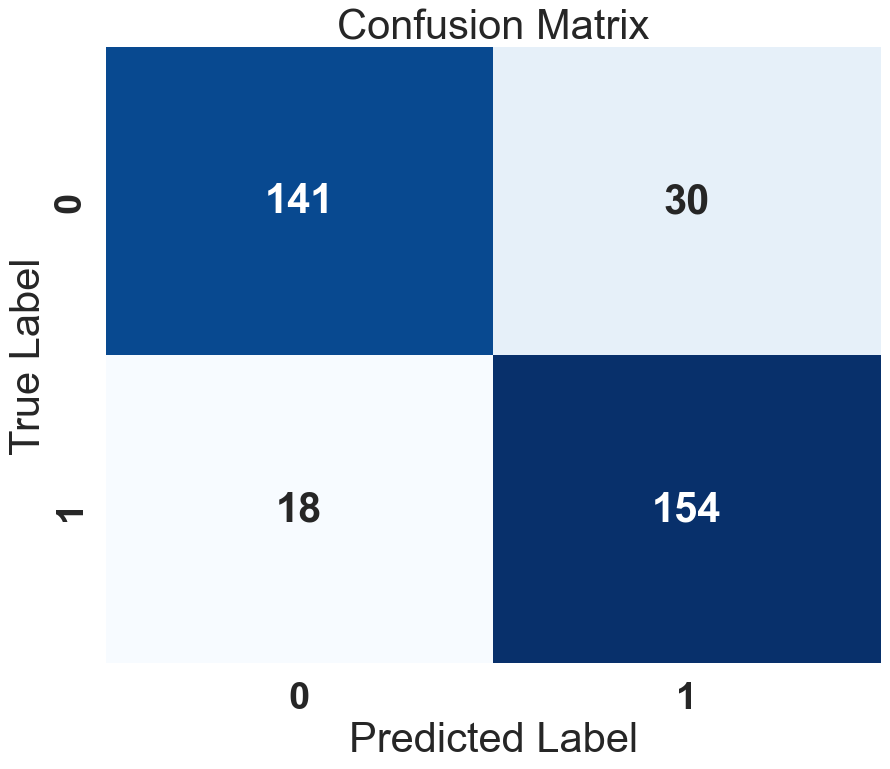

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Instantiate the RandomForestClassifier with the best parameters
best_rf_clf = RandomForestClassifier(random_state=42, oob_score=True, **grid_search.best_params_)

# Train the classifier
best_rf_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_clf.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [101]:
import os

In [102]:
os.getcwd()

'C:\\TEMP\\project'

In [103]:
from ngboost import NGBClassifier
from sklearn.metrics import roc_auc_score

# Instantiate the NgBoost classifier
clf_ngb = NGBClassifier(n_estimators=100, learning_rate=0.01, verbose=True, random_state=42)

# Fit the classifier to the training data
clf_ngb.fit(X_train, y_train)

# Predict probabilities for the test data
y_prob_ngb = clf_ngb.predict_proba(X_test)[:, 1]

# Evaluate the model's performance (e.g., using ROC AUC)
auc_ngb = roc_auc_score(y_test, y_prob_ngb)
print("ROC AUC Score (NgBoost):", auc_ngb)


ModuleNotFoundError: No module named 'ngboost'

In [ ]:
from ngboost import NGBClassifier
from sklearn.metrics import roc_auc_score

# Instantiate the NgBoost classifier
clf_ngb = NGBClassifier(n_estimators=100, learning_rate=0.01, verbose=True, random_state=42)



In [ ]:
# Fit the classifier to the training data
clf_ngb.fit(X_train, y_train)

In [ ]:
# Predict probabilities for the test data
y_prob_ngb = clf_ngb.predict_proba(X_test)[:, 1]

# Evaluate the model's performance (e.g., using ROC AUC)
auc_ngb = roc_auc_score(y_test, y_prob_ngb)
print("ROC AUC Score (NgBoost):", auc_ngb)


In [ ]:
from ngboost import NGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:

optimal_params.fit(X_train,y_train,
                   verbose=True,
                   eval_set=[(X_test,y_test)])

optimal_params.best_params_  

In [ ]:
from ngboost import NGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

# Assuming you have performed GridSearchCV and stored the results in optimal_params
optimal_params = {
    "n_estimators": 100,  # Example parameter, replace with actual ones
    "learning_rate": 0.01,  # Example parameter, replace with actual ones
    # Add other best parameters found by GridSearchCV
}

# Instantiate the NgBoost classifier with best parameters found by GridSearchCV
clf_ngb = NGBClassifier(verbose=True, random_state=4442, **optimal_params)

# Fit NgBoost classifier to the training data
clf_ngb.fit(X_train, y_train)

# Predictions on the test set
y_pred_ngb = clf_ngb.predict(X_test)

# Calculate confusion matrix
cm_ngb = confusion_matrix(y_test, y_pred_ngb)

# Display confusion matrix
disp_ngb = ConfusionMatrixDisplay(confusion_matrix=cm_ngb)
disp_ngb.plot()
